In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
eps = {'x': 0.4, 'y': 0.4}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# lines stored as [p_start, p_end] = [[x_st, y_st], [x_end, y_end]]
x1, y1, x2, y2 = 0.8, 0.3, 0.38, 0.9
lines = np.array([[[0, y1], [x1, 1]], [[1, y2], [x2, 0]]])

In [3]:
def intersect_with_square(line, gl_bounds):
    p_st, p_end = np.array(line)
    included_corners = []
    for x in gl_bounds['x']:
        for y in gl_bounds['y']:
            cross_pr = np.cross(p_end - p_st, np.array([x, y]) - p_st)
            if cross_pr > 0:
                included_corners.append([cross_pr, [x, y]])
    included_corners.sort(reverse=True)
    x_, y_ = [p_st[0], p_end[0]], [p_st[1], p_end[1]]
    for _, corner in included_corners:
        x_.append(corner[0])
        y_.append(corner[1])
    return x_, y_

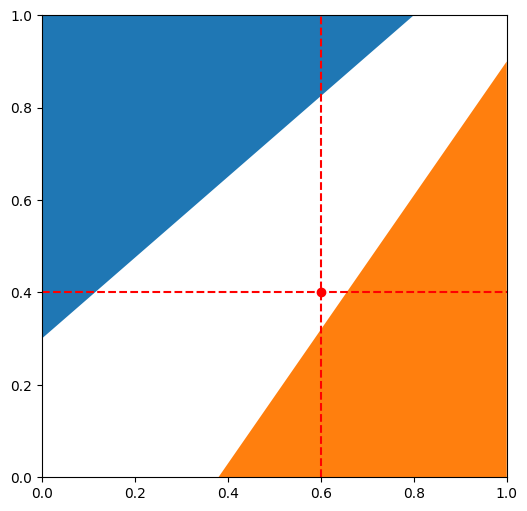

In [4]:
# square 1 x 1
def draw(fig, ax, lines, true_coords, gl_bounds):
    for line in lines:
        x, y = intersect_with_square(line, gl_bounds)
        ax.fill(x, y)
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw(fig, ax, lines, true_coords, gl_bounds)

In [5]:
def cross_product_2d(p1, p2):
    return p1[0] * p2[1] - p1[1] * p2[0]

def intersect_lines(line1, line2):
    # https://stackoverflow.com/a/565282
    p1, p2 = line1[0], line2[0]
    vec1, vec2 = line1[1] - line1[0], line2[1] - line2[0]
    vec_cross_pr = cross_product_2d(vec1, vec2)
    if vec_cross_pr == 0: # < 1e-6
        if cross_product_2d(p2 - p1, vec1) == 0: # < 1e-6
            return None # check if overlapping (we know they are collinear)
        else:
            return None
    else:
        coef1 = cross_product_2d(p2 - p1, vec2) / vec_cross_pr
        coef2 = cross_product_2d(p2 - p1, vec1) / vec_cross_pr
        if 0 <= coef1 and coef1 <= 1 and 0 <= coef2 and coef2 <= 1:
            return p1 + coef1 * vec1
        return None


def free_segment_length(coord, axis, lines, gl_bounds):
    # axis == 'x' means we want to find the length of horizontal segment,
    # i.e. y coordinate is fixed
    true_line = np.array([[gl_bounds['x'][0], coord], [gl_bounds['x'][1], coord]]) if axis == 'x' \
                    else np.array([[coord, gl_bounds['y'][0]], [coord, gl_bounds['y'][1]]])
    inter_line1 = intersect_lines(true_line, lines[0])
    inter_line2 = intersect_lines(true_line, lines[1])
    st_point = true_line[0] if inter_line1 is None else inter_line1
    end_point = true_line[1] if inter_line2 is None else inter_line2

    return np.linalg.norm(end_point - st_point)

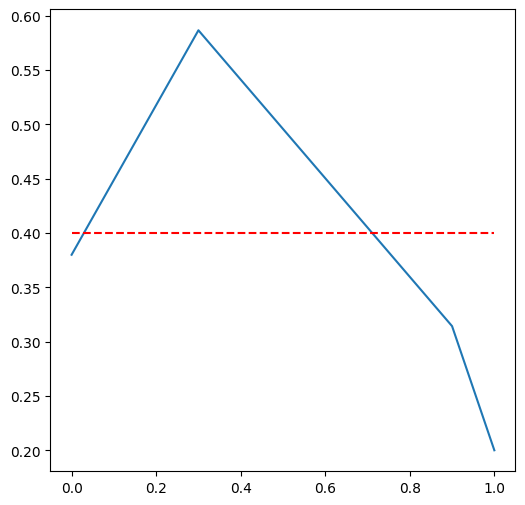

In [6]:
points = np.vstack(lines)
points = points[points[:, 1].argsort()]

x = []
y = []
for point in points:
    x.append(point[1])
    y.append(free_segment_length(point[1], 'x', lines, gl_bounds))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
ax.plot(x, y)
ax.hlines(eps['x'], 0, 1, colors='red', linestyle='dashed')
plt.show()